**1. Setting Up the Environment**

In [ ]:
# Install necessary libraries
!pip install kagglehub

# Import required libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**2. Data Preparation**

a. Mount Google Drive and Download Dataset

In [ ]:
from google.colab import files
files.upload()  # Select the 'kaggle.json' file from your local system

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shivareddy5152","key":"01b19a5a93ba0b6f4ecf0d052c1e9090"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:24<00:00, 68.2MB/s]
100% 2.70G/2.70G [00:24<00:00, 119MB/s] 


In [ ]:
dataset_path = '/content/New Plant Diseases Dataset(Augmented)'

b. Organize Dataset into Train and Validation Folders

In [ ]:
train_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
validation_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

In [ ]:
def ensure_class_in_validation(train_dir, val_dir, class_name, num_images=10):
    # Paths for the class in training and validation directories
    train_class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)

    # Create the class directory in validation if it doesn't exist
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path)

    # Count images in the validation class directory
    val_images_count = len(os.listdir(val_class_path))

    # Calculate the number of images to add if count is below the required number
    missing_images_count = num_images - val_images_count
    if missing_images_count > 0:
        # Select random images from the training class folder
        train_images = os.listdir(train_class_path)
        images_to_copy = random.sample(train_images, min(missing_images_count, len(train_images)))

        # Copy selected images to the validation directory
        for img_name in images_to_copy:
            src_path = os.path.join(train_class_path, img_name)
            dst_path = os.path.join(val_class_path, img_name)
            shutil.copy(src_path, dst_path)
        print(f"Added {missing_images_count} images to the '{class_name}' class in the validation set.")
    else:
        print(f"The '{class_name}' class in the validation set already has sufficient images.")

In [ ]:
# List of class names (ensure this matches the folder names in your dataset)
class_names = os.listdir(train_directory)

# Ensure each class in validation set has at least 10 images
for class_name in class_names:
    ensure_class_in_validation(train_directory, validation_directory, class_name, num_images=10)

The 'Tomato___Spider_mites Two-spotted_spider_mite' class in the validation set already has sufficient images.
The 'Cherry_(including_sour)___Powdery_mildew' class in the validation set already has sufficient images.
The 'Soybean___healthy' class in the validation set already has sufficient images.
The 'Tomato___Late_blight' class in the validation set already has sufficient images.
The 'Potato___healthy' class in the validation set already has sufficient images.
The 'Corn_(maize)___Common_rust_' class in the validation set already has sufficient images.
The 'Apple___Black_rot' class in the validation set already has sufficient images.
The 'Apple___Apple_scab' class in the validation set already has sufficient images.
The 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' class in the validation set already has sufficient images.
The 'Pepper,_bell___Bacterial_spot' class in the validation set already has sufficient images.
The 'Strawberry___Leaf_scorch' class in the validation set already ha

c. Load Image Paths and Labels into a DataFrame

In [ ]:
# Initialize lists to hold image paths and labels
image_files = []
labels = []

In [ ]:
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.png')):
            file_path = os.path.join(root, file)
            image_files.append(file_path)
            labels.append(os.path.basename(root))

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_files, 'label': labels})

# Display the first few rows
print(df.head())

                                          image_path                 label
0  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
1  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
2  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
3  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
4  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 image_path    0
label         0
dtype: int64


In [ ]:
# Check for duplicate rows
duplicates_count = df.duplicated().sum()
print("Number of Duplicate Rows:", duplicates_count)

# Display duplicate rows if any
if duplicates_count > 0:
    print("Duplicate Rows:\n", df[df.duplicated()])


Number of Duplicate Rows: 0


**3. Image Preprocessing**

a. Define Image Preprocessing Function

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check image shape
    if img_rgb.shape[:2] != target_size:
        img_rgb = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_LINEAR)

    # Create figure with 3 subplots for each channel
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']
    for i, ax in enumerate(axes):
        ax.imshow(img_rgb[:, :, i], cmap='gray')
        ax.set_title(f"{channels[i]} Channel")
        ax.axis('off')
    plt.show()

    # Plot histogram of pixel intensities
    plt.figure(figsize=(10, 4))
    plt.hist(img_rgb.ravel(), bins=256, color='gray', alpha=0.5)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

    # Image Manipulation Techniques
    # Sharpening
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])
    img_sharpen = cv2.filter2D(img_rgb, -1, kernel_sharpen)

    # Blurring
    img_blur = cv2.GaussianBlur(img_sharpen, (5, 5), 0)

    # Brightness and Contrast Adjustment
    alpha = 1.2  # Contrast control
    beta = 30    # Brightness control
    img_bright_contrast = cv2.convertScaleAbs(img_blur, alpha=alpha, beta=beta)

    # Adding Noise (Salt and Pepper)
    noise = np.random.randint(0, 50, (target_size[0], target_size[1], 3), dtype='uint8')
    img_noisy = cv2.add(img_bright_contrast, noise)

    return img_noisy

b. Apply Preprocessing to Sample Image

In [ ]:
# Select a sample image
sample_image_path = df['image_path'].iloc[0]
print(f"Sample Image Path: {sample_image_path}")

Sample Image Path: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight/29e924db-ef09-49f2-9db3-e3c548a444d5___GHLB_PS Leaf 17.1 Day 9.jpg


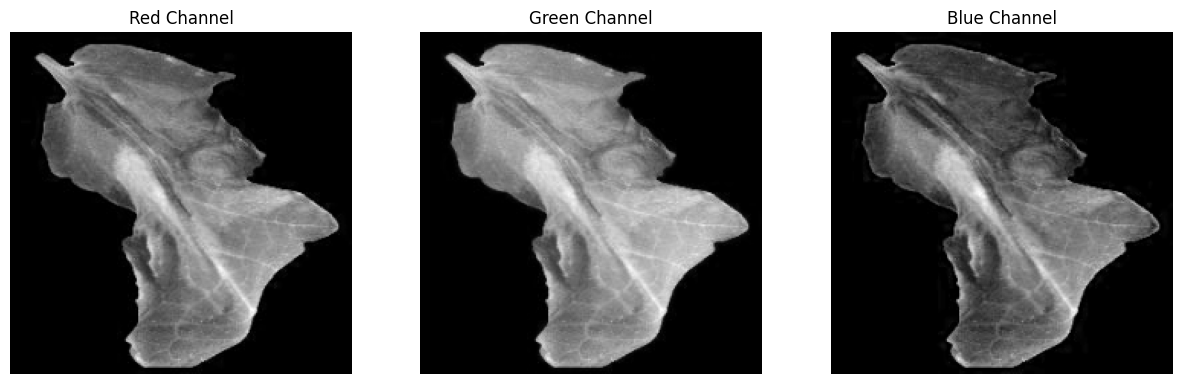

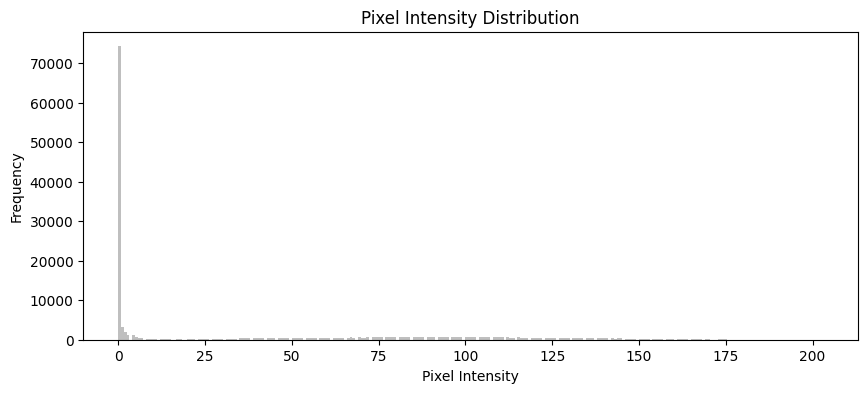

In [ ]:
# Preprocess the image
preprocessed_image = preprocess_image(sample_image_path)

**4. Setting Up ImageDataGenerators for Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),  # or whatever size your model requires
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
print("Training class indices:", train_generator.class_indices)
print("Validation class indices:", validation_generator.class_indices)

Training class indices: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___L

**5. Image Segmentation using OpenCV**

In [ ]:
# Function to segment the image
def segment_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    segmented_img = cv2.bitwise_and(image, mask)
    return segmented_img

Example for segmentation

In [ ]:
# Path to the train directory
train_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

# List contents of the train directory
try:
    train_contents = os.listdir(train_directory)
    print("Contents of the train directory:", train_contents)
except FileNotFoundError as e:
    print("Directory not found:", e)

Contents of the train directory: ['Tomato___Spider_mites Two-spotted_spider_mite', 'Cherry_(including_sour)___Powdery_mildew', 'Soybean___healthy', 'Tomato___Late_blight', 'Potato___healthy', 'Corn_(maize)___Common_rust_', 'Apple___Black_rot', 'Apple___Apple_scab', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Pepper,_bell___Bacterial_spot', 'Strawberry___Leaf_scorch', 'Blueberry___healthy', 'Raspberry___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Peach___Bacterial_spot', 'Tomato___Bacterial_spot', 'Grape___Esca_(Black_Measles)', 'Strawberry___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___healthy', 'Grape___Black_rot', 'Tomato___Target_Spot', 'Apple___healthy', 'Tomato___Leaf_Mold', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Peach___healthy', 'Tomato___Septoria_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Corn_(maize)___healthy', 'Apple___Cedar_apple_rust', 'Corn_(maize)___Northern_Leaf_Blight', 'Pepper,_bell___healthy', 'Grape___heal

Image path: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___healthy/bf91d1c5-83ae-42d4-bb95-a4a994ea8ed9___R.S_HL 8257 copy 2.jpg


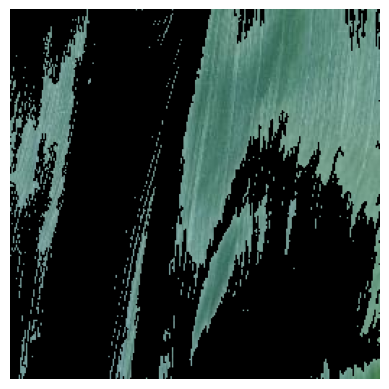

In [ ]:
folder_name = 'Corn_(maize)___healthy'  # Adjust this based on the output of previous steps
folder_path = os.path.join(train_directory, folder_name)

# List the image files in the directory
try:
    image_files = os.listdir(folder_path)

    # Ensure that there are images in the folder
    if image_files:
        # Select a random image file or choose the first one
        random_image_file = random.choice(image_files)  # or use image_files[0]

        # Create the full path to the image
        image_path = os.path.join(folder_path, random_image_file)

        # Print the image path for debugging
        print("Image path:", image_path)

        # Check if the image exists
        if os.path.exists(image_path):
            # Function for segmenting the image
            def segment_image(image_path):
                # Read the image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Could not read image {image_path}")
                    return None
                # Converting to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Applying a binary threshold to get a binary image
                _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

                # Finding contours
                contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Creating a mask for the segmented image
                mask = np.zeros_like(image)
                cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

                # Applying the mask to get the segmented image
                segmented_img = cv2.bitwise_and(image, mask)

                return segmented_img

            # Call the segmentation function
            segmented_img = segment_image(image_path)

            # Check if the image was segmented successfully
            if segmented_img is not None:
                plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
        else:
            print(f"Image file does not exist: {image_path}")
    else:
        print("No images found in the specified directory.")
except FileNotFoundError as e:
    print("Directory not found:", e)

Visual Validation

In [ ]:
# Select a few random images for validation
num_images_to_display = 5  # Number of images you want to validate
random_images = random.sample(image_files, min(num_images_to_display, len(image_files)))

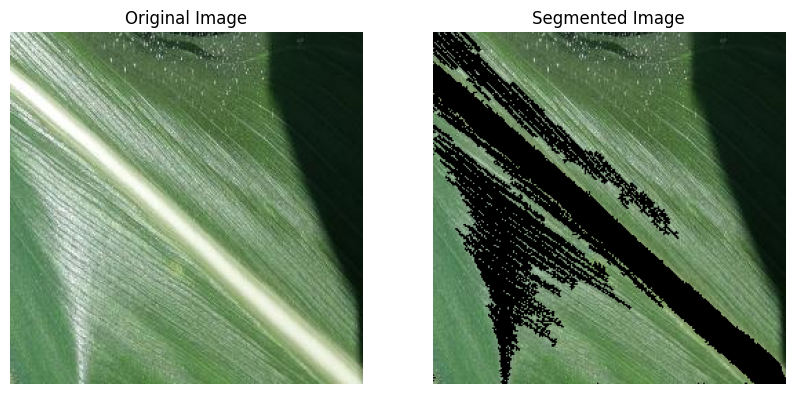

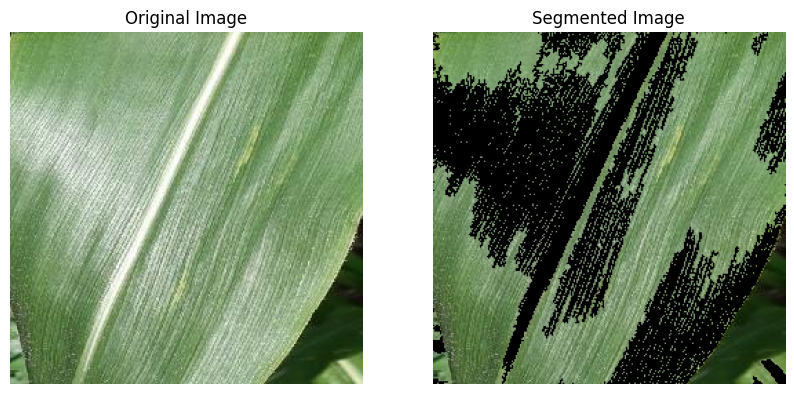

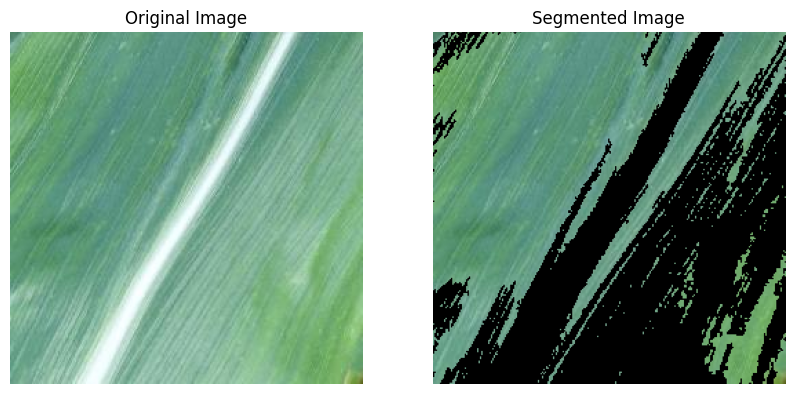

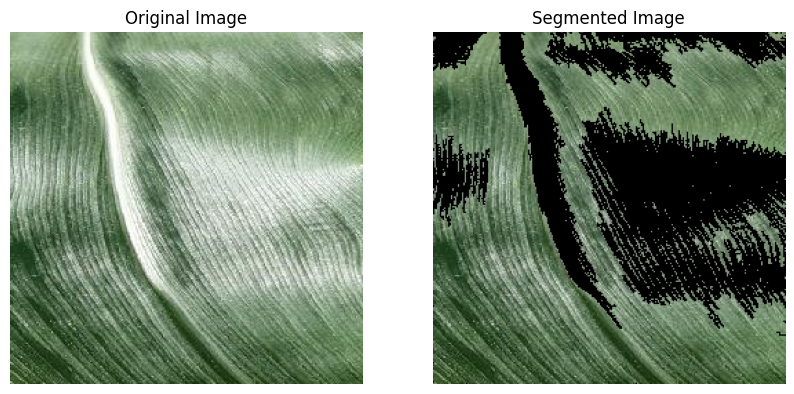

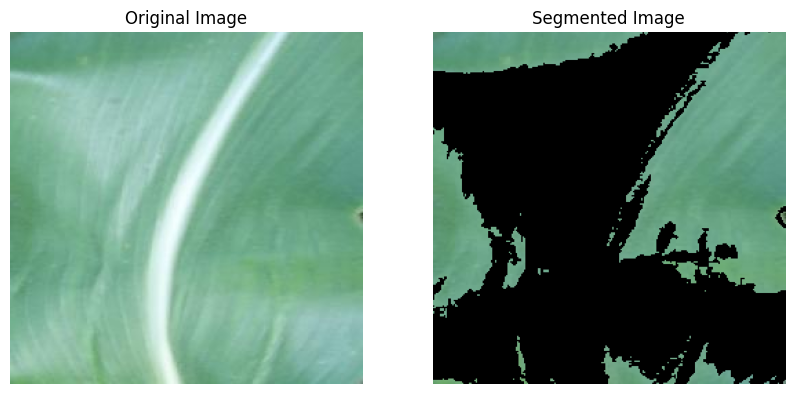

In [ ]:
# Loop through the selected images
for image_file in random_images:
    image_path = os.path.join(folder_path, image_file)

    # Segment the image
    segmented_img = segment_image(image_path)

    # Validate the results by displaying the original and segmented images
    original_img = cv2.imread(image_path)

    if segmented_img is not None:
        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display segmented image
        plt.subplot(1, 2, 2)
        plt.title('Segmented Image')
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

**6. Feature Engineering with Edge Detection**

a. Define Feature Extraction Function

In [ ]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imread

def extract_features(image_path):
    # Load the image
    image = imread(image_path)

    # Convert to grayscale (HOG works on grayscale images)
    if image.ndim == 3:  # Check if the image is RGB
        image = rgb2gray(image)

    # Extract HOG features
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )

    return features

b. Apply Feature Extraction to the Entire Dataset

In [ ]:
# Extract features for all images
feature_list = []
labels = []

for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']
    try:
        features = extract_features(image_path)
        feature_list.append(features)
        labels.append(label)
    except FileNotFoundError as e:
        print(e)

In [ ]:
# Convert to DataFrame
feature_df = pd.DataFrame(feature_list)
feature_df['label'] = labels

In [ ]:
# Display the first few rows
print(feature_df.head())

     0    1    2    3    4    5    6    7    8    9  ...  34587  34588  34589  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   34590  34591  34592  34593  34594  34595                 label  
0    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
1    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
2    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
3    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
4    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  

[5 rows x 34597 columns]


**5. Model Configuration and Training**

a. Load and Preprocess Data

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Encode the labels as integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# One-hot encode the integer-encoded labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Verify the one-hot encoded labels
print("One-hot encoded labels:\n", onehot_encoded[:5])
# Split the data
X = feature_df.drop('label', axis=1)
y = onehot_encoded

# Split without stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

One-hot encoded labels:
 [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)

In [ ]:
X_train_images = load_images(df.loc[X_train.index, 'image_path'].values)
X_val_images = load_images(df.loc[X_val.index, 'image_path'].values)

b. Prepare Lables

In [ ]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of y_train: (2436, 8)
Shape of y_val: (610, 8)


In [ ]:
# Use the one-hot encoded labels directly
y_train_encoded = y_train
y_val_encoded = y_val

c. Defining Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Determine the number of classes
num_classes = y_train_encoded.shape[1]

# Define the model
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use num_classes here
])

d. Compile the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # If labels are one-hot encoded
    metrics=['accuracy']
)

e. Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Stop if validation loss doesn’t improve for 2 epochs
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train_images, y_train_encoded,
    validation_data=(X_val_images, y_val_encoded),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.8067 - loss: 0.9219 - val_accuracy: 0.8967 - val_loss: 0.3046
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.9035 - loss: 0.2961 - val_accuracy: 0.9328 - val_loss: 0.1735
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.9329 - loss: 0.1928 - val_accuracy: 0.9443 - val_loss: 0.1416
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.9410 - loss: 0.1980 - val_accuracy: 0.9393 - val_loss: 0.1792
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.9665 - loss: 0.1087 - val_accuracy: 0.9590 - val_loss: 0.1620


**6. Model Evaluation and Finalization**

a. Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(X_val_images, y_val_encoded)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9430 - loss: 0.1317
Validation Loss: 0.14159329235553741, Validation Accuracy: 0.9442622661590576


b. Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/My Drive/PlantAI_Project.keras')

c. Visualize Training and Validation Metrics

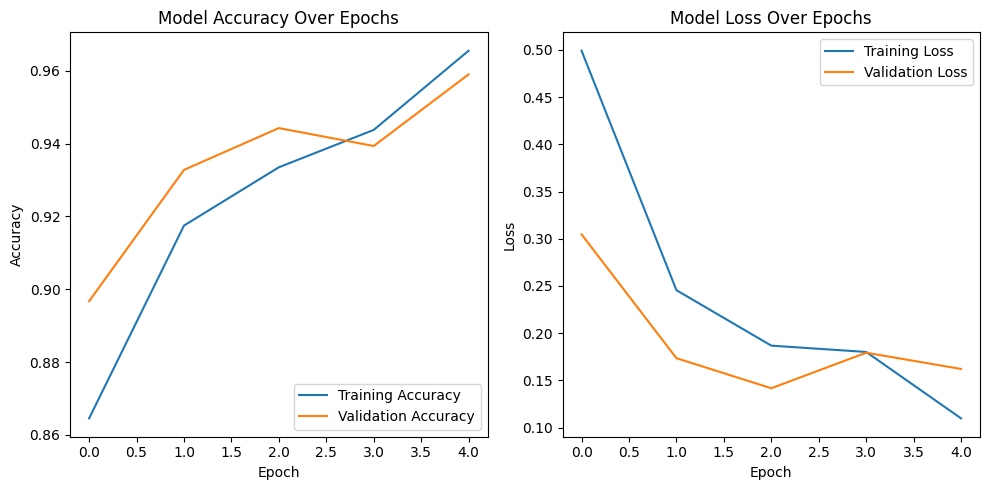

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### **Model Prediction**

In [ ]:
class_names

['Tomato___Spider_mites Two-spotted_spider_mite',
 'Cherry_(including_sour)___Powdery_mildew',
 'Soybean___healthy',
 'Tomato___Late_blight',
 'Potato___healthy',
 'Corn_(maize)___Common_rust_',
 'Apple___Black_rot',
 'Apple___Apple_scab',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Pepper,_bell___Bacterial_spot',
 'Strawberry___Leaf_scorch',
 'Blueberry___healthy',
 'Raspberry___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Peach___Bacterial_spot',
 'Tomato___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Strawberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___healthy',
 'Grape___Black_rot',
 'Tomato___Target_Spot',
 'Apple___healthy',
 'Tomato___Leaf_Mold',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Peach___healthy',
 'Tomato___Septoria_leaf_spot',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Corn_(maize)___healthy',
 'Apple___Cedar_apple_rust',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Pepper,_bell___healthy',
 'Grape___heal

In [ ]:
# Define the class names
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
    'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

a. Load the Trained Model

In [ ]:
# Path to your saved model
model_path = '/content/drive/My Drive/PlantAI_Project.keras'

# Load the model
model = tf.keras.models.load_model(model_path)

b. Set Up the Test Dataset

In [ ]:
# Path to your validation directory
validation_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Load the dataset without mapping transformations first
test_dataset = image_dataset_from_directory(
    validation_directory,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# Now you can access class_names
class_names = test_dataset.class_names  # List of class names

# Normalize the dataset
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

Found 17572 files belonging to 38 classes.


c. Define the Prediction Function

In [ ]:
def predict_disease(model, image_batch):
    # Make predictions
    predictions = model.predict(image_batch)

    # Find the indices of the maximum probabilities
    predicted_indices = np.argmax(predictions, axis=1)

    # Map indices to class names
    predicted_labels = [class_names[index] for index in predicted_indices]
    return predicted_labels

d. Predictions on the Test Dataset

In [ ]:
# Predict on one batch of images
for images, labels in test_dataset.take(1):  # Take the first batch
    predicted_diseases = predict_disease(model, images)

    # Display predictions
    for i, disease in enumerate(predicted_diseases):
        print(f"Image {i + 1} is predicted to have: {disease}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1 is predicted to have: Apple___Apple_scab
Image 2 is predicted to have: Apple___Cedar_apple_rust
Image 3 is predicted to have: Apple___Apple_scab
Image 4 is predicted to have: Apple___Cedar_apple_rust
Image 5 is predicted to have: Apple___Apple_scab
Image 6 is predicted to have: Apple___Cedar_apple_rust
Image 7 is predicted to have: Apple___Cedar_apple_rust
Image 8 is predicted to have: Cherry_(including_sour)___healthy
Image 9 is predicted to have: Apple___Apple_scab
Image 10 is predicted to have: Apple___Black_rot
Image 11 is predicted to have: Apple___Black_rot
Image 12 is predicted to have: Apple___Apple_scab
Image 13 is predicted to have: Apple___Black_rot
Image 14 is predicted to have: Apple___Apple_scab
Image 15 is predicted to have: Apple___Apple_scab
Image 16 is predicted to have: Apple___Cedar_apple_rust
Image 17 is predicted to have: Apple___Apple_scab
Image 18 is predicted to have: Apple___Apple_scab
Image 19 is predicted to have: 